# Курсын ажил (II)

## 0. Шаардлагатай санг оруулж ирэх өгөгдлөө унших

In [2]:
import tensorflow as tf

print(tf.__version__)

2.2.0-rc3


In [0]:
import csv
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os
from os.path import exists, join, basename, splitext
import sys

### Word2Vec Модел татаж авах

In [0]:
def download_from_google_drive_w2v(file_id, file_name):
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?id=$file_id&export=download" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=&id=$file_id" -o $file_name

file_path = 'word2vec'
if not exists(file_path):
  download_from_google_drive_w2v('1WpkY-PbcnAvfBzxDnQriWn81K2JZ56lS', '%s.model' % file_path)

### Өгөгдлөө татаж авах

In [56]:
import os
from os.path import exists, join, basename, splitext
import sys

def download_from_google_drive(file_id, file_name):
  !rm -f ./cookie
  !curl -c ./cookie -s -L "https://drive.google.com/uc?id=$file_id&export=download" > /dev/null
  confirm_text = !awk '/download/ {print $NF}' ./cookie
  confirm_text = confirm_text[0]
  !curl -Lb ./cookie "https://drive.google.com/uc?export=download&confirm=$confirm_text&id=$file_id" -o $file_name
  
# Өгөгдлөө уншиж авах
file_path = 'engLabelNewsData'
if not exists(file_path):
  download_from_google_drive('1Q-h9QkdmUyjjEhOvaRO9jHKdeWn8eGwd', '%s.csv' % file_path)


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   408    0   408    0     0   1387      0 --:--:-- --:--:-- --:--:--  1387
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  256M    0  256M    0     0   138M      0 --:--:--  0:00:01 --:--:--  334M


### Өгөгдлөө уншиж авах

In [43]:
articles = []
labels = []
datapath = 'engLabelNewsData.csv'
with open(datapath, 'r') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    labels.append(row[1])
    articles.append(row[0])
print(len(labels))
print(len(articles))


75661
75661


In [0]:
embedding_dim = 100
max_length = 200
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'
training_portion = .80

In [6]:
print(set(labels))

{'enviroment', 'economy', 'sport', 'politics', 'education', 'technology', 'art', 'law', 'health'}


In [8]:
print(len(labels))

75661


## Word2vec моделоо уншиж авах

In [9]:
word_model = Word2Vec.load('/content/drive/My Drive/text-classification-nn/word2vec.model')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:253: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [10]:
print(word_model.wv.most_similar('монгол'))
#print(word2vec_model["монгол"])

[('мон\xadгол', 0.6650691628456116), ('япон', 0.6176186800003052), ('турк', 0.5443229675292969), ('мьянмар', 0.5383078455924988), ('австри', 0.5067983865737915), ('вант', 0.4940747916698456), ('жүдо', 0.4768131971359253), ('хбнгу', 0.4722890257835388), ('бури', 0.4670514166355133), ('сингапур', 0.4581110179424286)]


/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


## Сургалтын баталгаажуулалтын өгөгдөл болгон хуваах

In [11]:
train_size = int(len(articles) * training_portion)

train_articles = articles[0: train_size]
train_labels = labels[0: train_size]

test_articles = articles[train_size:]
test_labels = labels[train_size:]

partial_index = 3000

validation_articles = train_articles[:partial_index]
train_articles = train_articles[partial_index:]

validation_labels = train_labels[:partial_index]
train_labels = train_labels[partial_index:]

print("Train size ",train_size)
print("Train news lenght ",len(train_articles))
print("Label lenght",len(train_labels))
print("Test news lenght",len(test_articles))
print("Test label lenght",len(test_labels))
print("Validation news lenght",len(validation_articles))
print("Validation label lenght",len(validation_labels))

Train size  60528
Train news lenght  57528
Label lenght 57528
Test news lenght 15133
Test label lenght 15133
Validation news lenght 3000
Validation label lenght 3000


## Ижил урттай болгох


### Сургалтын өгөгдлийн хувьд

In [12]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(articles)

word_index = tokenizer.word_index
vocab_size=len(word_index)
# Сургалтын хэсэг
train_sequences = tokenizer.texts_to_sequences(train_articles)
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(train_sequences[0]))
print(len(train_padded[0]))

print(len(train_sequences[1]))
print(len(train_padded[1]))

print(len(train_sequences[10]))
print(len(train_padded[10]))

118
200
107
200
139
200


In [13]:
print(len(word_index))

472967


### Баталгаажуулалтын өгөгдлийн хувьд

In [14]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(validation_sequences))
print(validation_padded.shape)

3000
(3000, 200)


### Тест өгөгдлийн хувьд

In [15]:
test_sequences = tokenizer.texts_to_sequences(test_articles)
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

print(len(test_sequences))
print(test_padded.shape)

15133
(15133, 200)


### Label-ийн хувьд

In [0]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(labels)

training_label_seq = np.array(label_tokenizer.texts_to_sequences(train_labels))
validation_label_seq = np.array(label_tokenizer.texts_to_sequences(validation_labels))
test_label_seq = np.array(label_tokenizer.texts_to_sequences(test_labels))

## Embedding matrix бэлтгэх

In [17]:
import numpy as np

words_not_found = []
embedding_matrix = np.random.uniform(-1, 1, (vocab_size, embedding_dim))
for word, i in word_index.items():
  if i<4:
    continue
  try:
    embedding_vector = word_model[word]
    if (embedding_vector is not None) and len(embedding_vector) > 0:
      embedding_matrix[i] = embedding_vector
  except:
    words_not_found.append(word)
    pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


In [18]:
print(embedding_matrix.shape)

(472967, 100)


## Моделоо бэлтгэх, сургалт

In [25]:

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim,
                             input_length=max_length),

    tf.keras.layers.Conv1D(128, 9, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(10, activation='sigmoid')
])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 200, 100)          47296800  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 192, 128)          115328    
_________________________________________________________________
global_average_pooling1d_2 ( (None, 128)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_5 (Dense)              (None, 10)                650       
Total params: 47,421,034
Trainable params: 47,421,034
Non-trainable params: 0
_________________________________________________________________


jj

In [0]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
num_epochs = 10
history = model.fit(train_padded,
                    training_label_seq,
                    epochs=num_epochs,
                    batch_size=512,
                    validation_data=(validation_padded, validation_label_seq),
                    verbose=1)

Epoch 1/10
113/113 [==============================] - 31s 276ms/step - loss: 1.7234 - accuracy: 0.2661 - val_loss: 1.6552 - val_accuracy: 0.2857
Epoch 2/10
113/113 [==============================] - 30s 268ms/step - loss: 0.4978 - accuracy: 0.8508 - val_loss: 0.7287 - val_accuracy: 0.7833
Epoch 3/10
113/113 [==============================] - 30s 269ms/step - loss: 0.2502 - accuracy: 0.9265 - val_loss: 0.5820 - val_accuracy: 0.8200
Epoch 4/10
113/113 [==============================] - 30s 269ms/step - loss: 0.1463 - accuracy: 0.9583 - val_loss: 0.5430 - val_accuracy: 0.8333
Epoch 5/10
113/113 [==============================] - 30s 269ms/step - loss: 0.0895 - accuracy: 0.9744 - val_loss: 0.5497 - val_accuracy: 0.8447
Epoch 6/10
113/113 [==============================] - 30s 268ms/step - loss: 0.0611 - accuracy: 0.9822 - val_loss: 0.5396 - val_accuracy: 0.8537
Epoch 7/10
113/113 [==============================] - 31s 270ms/step - loss: 0.0480 - accuracy: 0.9853 - val_loss: 0.5566 - val_ac

In [28]:
results = model.evaluate(test_padded, test_label_seq)
print(results)

473/473 [==============================] - 1s 3ms/step - loss: 4.0365 - accuracy: 0.5651
[4.036470890045166, 0.5651226043701172]


###  Дүрслэх

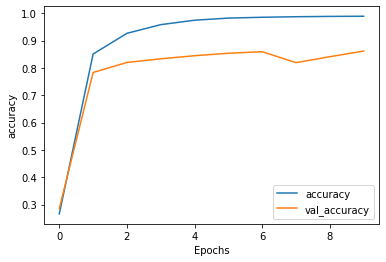

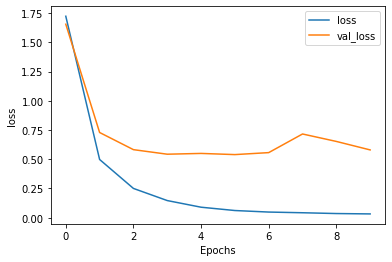

In [29]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Энгийн туршилт

In [30]:
txt = ["спортын төв ордонд өнөөдөр азийн оюутны аварга шалгаруулах эмэгтэй волейболчдын хоёр дахь удаагийн тэмцээний талаар мэдээлэл хийлээ"]
seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)
labels = ['health', 'sport', 'technology', 'economy', 'law', 'education', 'enviroment', 'art', 'politics']
print(pred, labels[np.argmax(pred)])

[[2.0459769e-08 3.5800977e-04 9.8384980e-06 4.0090267e-06 6.8675212e-07
  1.1366253e-05 3.3772633e-07 9.9093650e-06 3.1414499e-10 5.8691080e-07]] sport
